# solving rate equations for the multi-photon multiple ionization dynamics due to intense x-ray radiation

CFEL 2022, Ludger Inhester

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
AU2SEC = 2.418884326500e-17
FS2AU = 1e-15 / AU2SEC
AU2FS = 1 / FS2AU
AU2M = 0.5291772083e-10
M2AU = 1. / AU2M

In [2]:
def solveREQ(pIni,
             processData,
             configurations,
             fluence,
             pulseEnv,
             tStart=-150 * FS2AU,
             tEnd=150 * FS2AU,
             dt=0.1 * FS2AU,
             method='LSODA'):
    """
    solves the rate equation and returns results for the population
    Mandatory arguments: 
        pIni: initial population, array of shape(nconfigurations)
        processData: process data, dictionary obtained from readProcessData
        configurations: array of configurations, array of shape (nconfigurations, number of occupations)
        fluence: fluence value, scalar (number of photons per area in atomic units)
        pulseEnv: pulseEnvelop, function f(t), t in atomic units  
    optional arguments:
        tStart: time to start integration (i.e., where p=pIni) in atomic units, default -100*FSAU
        tEnd: time to end integration in atomic units, default 100*FSAU
        dt: timestep in atomic units for which to provide results, default 0.1*FSAU.
            The timestep is also used as maximal timestep for the integrator. 
            It must be equal or smaller than the pulse duration.
        method: one of 'RK23', 'RK45', 'BDF', 'LSODA', 'Radau', 'DOP853'
    returns:
        res: return results object of scipy.integrate.solve_ivp
        in particular
        res['t'] time values
        res['y'] population values at different times
    """
    confDict = {str(c): i for i, c in enumerate(configurations)}
    gammas = [{
        'i': confDict[str(proc['iconfig'])],
        'f': confDict[str(proc['fconfig'])],
        'rate': proc['rate']
    } for proc in processData if proc['type'] == 'A' or proc['type'] == 'F']
    sigmas = [{
        'i': confDict[str(proc['iconfig'])],
        'f': confDict[str(proc['fconfig'])],
        'pcs': proc['pcs']
    } for proc in processData if proc['type'] == 'P' or proc['type'] == 'V']

    def REQ(t, p):
        """
        returns dp/dt (the right-hand-side of the diff. eq.)
        """
        pDot = np.zeros(p.shape)
        Ipulse = pulseEnv(t) * fluence
        for s in sigmas:
            pDot[s['i']] += -s['pcs'] * Ipulse * p[s['i']]
            pDot[s['f']] += +s['pcs'] * Ipulse * p[s['i']]
        for g in gammas:
            pDot[g['i']] += -g['rate'] * p[g['i']]
            pDot[g['f']] += +g['rate'] * p[g['i']]
        return (pDot)

    def REQjac(t, p):
        """
         returns d/dpj dp_i/dt (jacobian of the right-hand-side of the diff. eq.)
        """
        pDot = REQ(t, p)
        pDotjac = np.zeros((p.shape[0], p.shape[0]))
        Ipulse = pulseEnv(t) * fluence
        for s in sigmas:
            pDotjac[s['i'], s['i']] += -s['pcs'] * Ipulse
            pDotjac[s['f'], s['i']] += +s['pcs'] * Ipulse
        for g in gammas:
            pDotjac[g['i'], g['i']] += -g['rate']
            pDotjac[g['f'], g['i']] += +g['rate']
        return (pDotjac)

    times = np.arange(tStart, tEnd, dt)
    if method == 'RK45' or method == 'RK23' or method == 'Radau' or method == 'DOP853':
        res = solve_ivp(REQ, (tStart - dt, tEnd + dt),
                        pIni,
                        t_eval=times,
                        method=method,
                        max_step=dt)
    elif method == 'LSODA' or method == 'BDF':
        res = solve_ivp(REQ, (tStart - dt, tEnd + dt),
                        pIni,
                        t_eval=times,
                        method='LSODA',
                        jac=REQjac,
                        max_step=dt)
    else:
        raise ValueError(f"method={method} unknown")
    if not res.success:
        print(res.message)
    return res

In [3]:
def readProcessData(filename):
    """
    reads in and returns process data generated by xatom from file filename
    """
    processData = []
    with open(filename, 'r') as f:
        lines = f.readlines()
        for line in lines:
            line = line.rstrip()
            els = line.split()
            if len(els) == 0:
                continue
            configs = line.split('#')[1].split('->')
            if (els[0] == 'P' or els[0] == 'V'):
                processData.append({
                    "type":
                    els[0],
                    "i":
                    els[1],
                    "f":
                    els[2],
                    "pcs":
                    float(els[3]),
                    "energy":
                    els[4],
                    "iconfig":
                    np.array([int(n) for n in configs[0].split()]),
                    "fconfig":
                    np.array([int(n) for n in configs[1].split()]),
                })
            else:
                processData.append({
                    "type":
                    els[0],
                    "i":
                    els[1],
                    "f":
                    els[2],
                    "rate":
                    float(els[3]),
                    "energy":
                    els[4],
                    "iconfig":
                    np.array([int(n) for n in configs[0].split()]),
                    "fconfig":
                    np.array([int(n) for n in configs[1].split()]),
                })
        return processData

In [4]:
def gaussian(x, sigma=10 * FS2AU, x0=0.):
    """
    Gaussian function:
    x0 is the center
    sigma is the stdev
    """
    return 1. / np.sqrt(2 * np.pi) * 1 / sigma * np.exp(-0.5 *
                                                        ((x - x0) / sigma)**2)

## Initial 3-configuration example

In [ ]:
pIni = np.array([1., 0., 0., 0.])
sigma = 1.
Gamma = 3 / 2
processData = [
    {
        "iconfig": np.array([1, 1]),
        "fconfig": np.array([0, 1]),
        "pcs": sigma,
        "type": "P"
    },
    {
        "iconfig": np.array([0, 1]),
        "fconfig": np.array([0, 0]),
        "pcs": sigma,
        "type": "P"
    },
    {
        "iconfig": np.array([0, 1]),
        "fconfig": np.array([1, 0]),
        "rate": Gamma,
        "type": "A"
    },
]
configurations = [
    np.array([1, 1]),
    np.array([0, 1]),
    np.array([0, 0]),
    np.array([1, 0])
]
fluence = 1.
pulseEnv = lambda t: 1. if t > 0 else 0.

res = solveREQ(pIni,
               processData,
               configurations,
               fluence,
               pulseEnv,
               tStart=0,
               tEnd=10,
               dt=0.1,
               method='LSODA')

In [ ]:
times = res['t']
p = res['y']
# plot populations and compare to analytical solution
fig, ax = plt.subplots()
ax.plot(times, p[0, :], label=r'$p_1$')
ax.plot(times, p[1, :], label=r'$p_2$')
ax.plot(times, p[2, :], label=r'$p_3$')
ax.plot(times, p[3, :], label=r'$p_4$')

ax.set_xlabel('time')
ax.set_ylabel('population')
ax.legend()
plt.show()

### Below is the solution for exercise 3a

In [ ]:
def analyticalSolution(t, sigma, Gamma):
    p1 = np.exp(-sigma * t)
    p2 = sigma / Gamma * (np.exp(-sigma * t) - np.exp(-(sigma + Gamma) * t))
    p3 = sigma / (sigma + Gamma) - sigma / Gamma * np.exp(
        -sigma * t) + sigma**2 / (Gamma * sigma + Gamma**2) * np.exp(
            -(sigma + Gamma) * t)
    p4 = 1 - p1 - p2 - p3
    return np.array([p1, p2, p3, p4])

In [ ]:
pA = analyticalSolution(times, sigma, Gamma)

# plot populations and compare to analytical solution
fig, ax = plt.subplots()
ax.plot(times, p[0, :], label=r'$p_1$')
ax.plot(times, pA[0, :], 'x', label=r'analytical')

ax.plot(times, p[1, :], label=r'$p_2$')
ax.plot(times, pA[1, :], 'x', label=r'analytical')

ax.plot(times, p[2, :], label=r'$p_3$')
ax.plot(times, pA[2, :], 'x', label=r'analytical')

ax.plot(times, p[3, :], label=r'$p_4$')
ax.plot(times, pA[3, :], 'x', label=r'analytical')

ax.set_xlabel('time')
ax.set_ylabel('population')
ax.legend(loc='upper center', ncol=4)
plt.show()

### End of solution for exercise 3a

# Rate Equation Solving with Calculated Atomic Data

# read an preprocess the process data (rates and cross sections calculated by xatom)

In [11]:
# read in process data: neon, 2000eV
processData = readProcessData('results_O_750.dat')

# get a list of involved electronic configurations
configurations = np.unique(np.array([p['iconfig'] for p in processData] +
                                    [p['fconfig'] for p in processData]),
                           axis=0)
Nc = configurations.shape[0]

# compute number of electrons for each configuration
Nelectron = np.array([np.sum(c) for c in configurations])

# initial population we start with the configuration that has the maximum number of electrons
startCfgIdx = np.argmax(Nelectron)
pIni = np.zeros(Nc)
pIni[startCfgIdx] = 1.

# Assume that nuclear charge is identical to maximum number of electron,
# i.e., the configuration with the most electrons is neutral
nuclearCharge = np.max(Nelectron)

# solve rate equation

In [16]:
%%time
# set pulse parameters:
# the fluence number of photons per micrometer square
nPhotonsPerSqmuM = 1.5e13 
# the pulse width (FWHM)
fwhmPulse = 25 * FS2AU
# convert fluence into atomic units and pulse width FWHM into stdev (atomic units)
fluence = nPhotonsPerSqmuM / (1e-6 * M2AU)**2
sigmaPulse = fwhmPulse / (2. * np.sqrt(2. * np.log(2.)))
# pulse Envelope: simple Gaussian with stddev 25fs and t0 = 0fs
pulseEnvelope = lambda t: gaussian(t, sigma=sigmaPulse, x0=0.0 * FS2AU)

res = solveREQ(pIni,
               processData,
               configurations,
               fluence,
               pulseEnvelope,
               method='LSODA')

# p is population, times is timepoints
p = res['y']
times = res['t']

# compute the average charge per time
avgCharge = nuclearCharge - np.dot(Nelectron, p)

# compute the population in a given charge state per time
chargePops = np.zeros((nuclearCharge + 1, p.shape[1]))
for q in range(chargePops.shape[0]):
    idx = np.where(nuclearCharge - Nelectron == q)[0]
    chargePops[q, :] = np.sum(p[idx, :], axis=0)

CPU times: user 534 ms, sys: 801 µs, total: 534 ms
Wall time: 536 ms


# plot/analyze the results

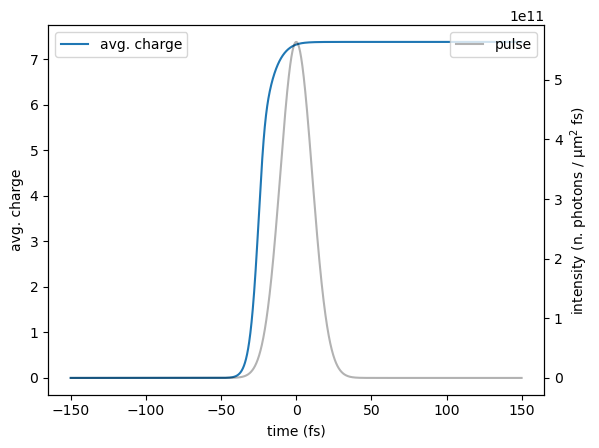

In [17]:
# plot Average Charge
fig, ax = plt.subplots()
ax2 = ax.twinx()

ax.plot(times / FS2AU, avgCharge, label='avg. charge')
ax2.plot(times / FS2AU,
         fluence * pulseEnvelope(times) * 1 / AU2FS * 1 / ((1e6 * AU2M)**2),
         label='pulse',
         c='black',
         alpha=0.3)

ax.set_xlabel('time (fs)')
ax.set_ylabel('avg. charge')
ax2.set_ylabel(r'intensity (n. photons / $\mathrm{\mu m}^2$ fs)')
ax.legend()
ax2.legend()
plt.show()

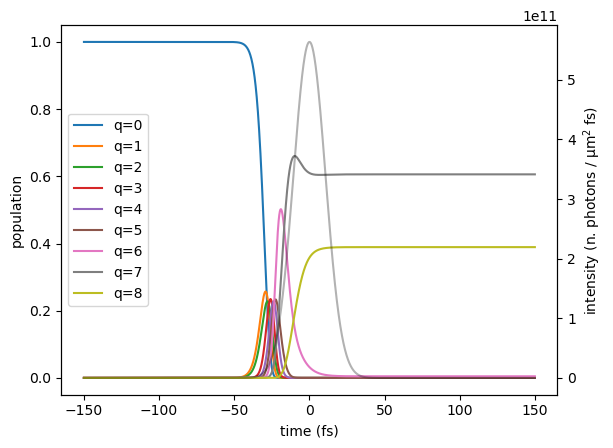

In [18]:
# plot charge population
fig, ax = plt.subplots()
ax2 = ax.twinx()
for q in range(chargePops.shape[0]):
    ax.plot(times / FS2AU, chargePops[q, :], label=f'q={q}')

ax2.plot(times / FS2AU,
         fluence * pulseEnvelope(times) * 1 / AU2FS * 1 / ((1e6 * AU2M)**2),
         label='pulse',
         c='black',
         alpha=0.3)
ax.legend()
ax.set_xlabel('time (fs)')
ax.set_ylabel('population')
ax2.set_ylabel(r'intensity (n. photons / $\mathrm{\mu m}^2$ fs)')
plt.show()

In [19]:
# ratio of PP vs PA processes:
# i.e. either A or P starting from configuration 1,2,6
# determine the singly core ionized configuration
cfgP = [
    p['fconfig'] for p in processData
    if np.all(p['iconfig'] == np.array(configurations[startCfgIdx]))
    and p['type'] == 'P'
][0]
print(
    f"Singly core ionized configuration has electronic occupation numbers {cfgP}"
)
# index of singly core ionized configuration
idxP = np.argmax(np.all(configurations == cfgP, axis=1))
# find the total photoionization c.s. and the Auger-Meitner decay rate for configuration idxP
sigmaPP = np.sum([
    p['pcs'] for p in processData
    if np.all(p['iconfig'] == configurations[idxP]) and p['type'] == 'P'
])
GammaPA = np.sum([
    p['rate'] for p in processData
    if np.all(p['iconfig'] == configurations[idxP]) and p['type'] == 'A'
])
# probability for PP is
# int dt sigma * F(t) p_P(t)
# probability for PA is
# int dt Gamma * p_P(t)
dt = times[1] - times[0]
probPP = np.sum(sigmaPP * fluence * pulseEnvelope(times) * p[idxP, :]) * dt
probPA = np.sum(GammaPA * p[idxP, :]) * dt

print(
    f"The probability for PP is {probPP}.\nThe probability for PA is {probPA}.\nRatio PP/PA is {probPP/probPA}"
)

Singly core ionized configuration has electronic occupation numbers [1 2 4]
The probability for PP is 0.40088334372339834.
The probability for PA is 0.4820026678699649.
Ratio PP/PA is 0.8317035785195053


In [33]:
[p for p in processData if np.all(p['iconfig'] == np.array(configurations[startCfgIdx]))]

[{'type': 'P',
  'i': '45',
  'f': '44',
  'pcs': 0.008532284158464506,
  'energy': '213',
  'iconfig': array([2, 2, 4]),
  'fconfig': array([1, 2, 4])},
 {'type': 'V',
  'i': '45',
  'f': '42',
  'pcs': 0.0003873479622629958,
  'energy': '721',
  'iconfig': array([2, 2, 4]),
  'fconfig': array([2, 1, 4])},
 {'type': 'V',
  'i': '45',
  'f': '36',
  'pcs': 0.0001015465060570277,
  'energy': '736',
  'iconfig': array([2, 2, 4]),
  'fconfig': array([2, 2, 3])}]

In [35]:
[p for p in processData if np.all(p['iconfig'] == np.array(configurations[idxP])) and p['type']=='A']

[{'type': 'A',
  'i': '44',
  'f': '39',
  'rate': 0.0009139013893710296,
  'energy': '513',
  'iconfig': array([1, 2, 4]),
  'fconfig': array([2, 0, 4])},
 {'type': 'A',
  'i': '44',
  'f': '33',
  'rate': 0.001850087889632101,
  'energy': '528',
  'iconfig': array([1, 2, 4]),
  'fconfig': array([2, 1, 3])},
 {'type': 'A',
  'i': '44',
  'f': '27',
  'rate': 0.002553547336205528,
  'energy': '542',
  'iconfig': array([1, 2, 4]),
  'fconfig': array([2, 2, 2])}]

In [36]:
fluence

42004.27766762723

### below is the solution for exercise 3b, 3c, 3d

In [ ]:
fluences = np.linspace(1e11, 1e13, 21) / (1e-6 * M2AU)**2
finalAvgCharges = []
probPPs = []
probPAs = []
fwhmPulse = 25 * FS2AU
print(f"pulse duration = {fwhmPulse*AU2FS: 5.2f} fs ")
for fluence in fluences:
    sigmaPulse = fwhmPulse / (2. * np.sqrt(2. * np.log(2)))
    # pulse Envelope: simple Gaussian with stddev 25fs and t0 = 0fs
    pulseEnvelope = lambda t: gaussian(t, sigma=sigmaPulse, x0=0.0 * FS2AU)
    res = solveREQ(pIni, processData, configurations, fluence, pulseEnvelope)
    # p is population, times is timepoints
    p = res['y']
    times = res['t']
    # compute the average charge for the last time step
    finalAvgCharge = nuclearCharge - np.dot(Nelectron, p[:, -1])
    # computer the PP and PA probs
    dt = times[1] - times[0]
    probPP = np.sum(sigmaPP * fluence * pulseEnvelope(times) * p[idxP, :]) * dt
    probPA = np.sum(GammaPA * p[idxP, :]) * dt
    print(
        f"fluence = {fluence *  (1e-6 * M2AU)**2:10.2e} charge = {finalAvgCharge:5.2f} probPP = {probPP:5.2f} probPA = {probPA:5.2f} "
    )
    finalAvgCharges.append(finalAvgCharge)
    probPPs.append(probPP)
    probPAs.append(probPA)

finalAvgCharges = np.array(finalAvgCharges)
probPPs = np.array(probPPs)
probPAs = np.array(probPAs)

In [ ]:
# plot average charge as a function of fluence
fig, ax = plt.subplots()
ax.plot(fluences * (1e-6 * M2AU)**2, finalAvgCharges)
ax.set_xlabel(r'fluence (photons per $\mathrm{\mu m}^2$)')
ax.set_ylabel('final avg. Charge')
plt.ylim((0, nuclearCharge))
plt.show()

In [ ]:
# plot probability of PP / PA as a function of fluence
fig, ax = plt.subplots()
ax.plot(fluences * (1e-6 * M2AU)**2, probPPs, label='PP')
ax.plot(fluences * (1e-6 * M2AU)**2, probPAs, label='PA')

ax.set_xlabel(r'fluence (photons per $\mathrm{\mu m}^2$)')
ax.set_ylabel('probability')
plt.legend()
plt.show()

In [ ]:
finalAvgCharges = []
probPPs = []
probPAs = []
pulseDurations = np.array([
    0.2, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0, 3.0, 5.0, 7.0, 10.0, 15.0, 20.0, 25.0,
    30.
]) * FS2AU
fluence = 2e12 / (1e-6 * M2AU)**2
print(f"fluence = {fluence *  (1e-6 * M2AU)**2:10.2e}")
for fwhmPulse in pulseDurations:
    sigmaPulse = fwhmPulse / (2. * np.sqrt(2. * np.log(2)))
    # pulse Envelope: simple Gaussian with stddev sigmaPulse and t0 = 0fs
    pulseEnvelope = lambda t: gaussian(t, sigma=sigmaPulse, x0=0.0 * FS2AU)
    res = solveREQ(pIni, processData, configurations, fluence, pulseEnvelope)
    # p is population, times is timepoints
    p = res['y']
    times = res['t']
    finalAvgCharge = nuclearCharge - np.dot(Nelectron, p[:, -1])
    # computer the PP and PA probs
    dt = times[1] - times[0]
    probPP = np.sum(sigmaPP * fluence * pulseEnvelope(times) * p[idxP, :]) * dt
    probPA = np.sum(GammaPA * p[idxP, :]) * dt

    print(
        f"pulse duration = {fwhmPulse*AU2FS: 5.2f} fs  charge = {finalAvgCharge:5.2f} probPP = {probPP:5.2f} probPA = {probPA:5.2f}"
    )

    finalAvgCharges.append(finalAvgCharge)
    probPPs.append(probPP)
    probPAs.append(probPA)
finalAvgCharges = np.array(finalAvgCharges)
probPPs = np.array(probPPs)
probPAs = np.array(probPAs)

In [ ]:
# plot Average Charge as a function of pulse duration
fig, ax = plt.subplots()
ax.plot(pulseDurations * AU2FS, finalAvgCharges)
ax.set_xlabel('pulse duration FWHM (fs)')
ax.set_ylabel('final avg. charge')
plt.ylim((0, nuclearCharge))
plt.show()

In [ ]:
# plot probability of PP / PA as a function of pulse duration
fig, ax = plt.subplots()
ax.plot(pulseDurations * AU2FS, probPPs, label='PP')
ax.plot(pulseDurations * AU2FS, probPAs, label='PA')
ax.set_xlabel('pulse duration FWHM (fs)')
ax.set_ylabel('probability')
plt.legend()
plt.show()